1. 2d rgb에서 yolo 진행
2. Depth에 yolo에서 얻은 ROI 적용
3. Camera intrinsic Load
4. ROI depth -> 3d PCD 진행 
5. 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행 
6. PCA 수행하여 주요 축 추출
7. 법선과 PCA축을 통해 좌표계 구성
8. 회전행렬을 통해 RPY변환

In [1]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

import sys
sys.path.append(os.path.abspath("/home/ros/llm_robot"))
from utils.pixel_to_cam_coords import detect_objects
from utils.camera import load_intrinsics, capture_d455_images
# from utils.cam_to_base import cam2base, euler_to_rotation_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [46]:
import time
from pymycobot import MyCobot280

SERIAL_PORT = "/dev/ttyACM2"
BAUD_RATE = 115200

mc = MyCobot280(SERIAL_PORT, BAUD_RATE)

In [241]:
mc.get_servo_temps()

[31, 32, 32, 55, 50, 38]

In [253]:
mc.release_all_servos()
input("Press Enter to continue...")
mc.power_on()
mc.get_coords(), mc.get_angles()

([46.5, -63.7, 421.1, -89.64, 0.26, -90.43],
 [-0.61, -0.52, 0.0, 0.96, 0.17, 0.26])

### 1. 2D RGB에서 YOLO 수행하여 ROI 가져오기

In [266]:
c_path, d_path, intr_path = capture_d455_images()
MODEL_DIR = "/home/ros/llm_robot/yolo/runs/pose/yolo11n_640_500ep/weights/best.pt"

In [ ]:
camera_matrix, dist_coeffs = load_intrinsics(intr_path)
result = detect_objects(c_path, d_path, ["cube"], camera_matrix, dist_coeffs, MODEL_DIR)


image 1/1 /home/ros/llm_robot/data/captures/color/2025-08-27_16-39-31.jpg: 384x640 2 cubes, 10.6ms
Speed: 1.1ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.519 m  cam=(0.060, 0.031, 0.519)
cube        z=0.554 m  cam=(-0.160, -0.209, 0.554)


In [269]:
# bbox 추출 (yolo 수행 시 pytorch tensor 형식이 GPU 상에 올라가 있는 경우가 많기 때문에, cpu로 옮겨줌.)
boxes = result[0]["bbox"]
x1, y1, x2, y2 = boxes
print(x1, y1, x2, y2)

457 256 496 286


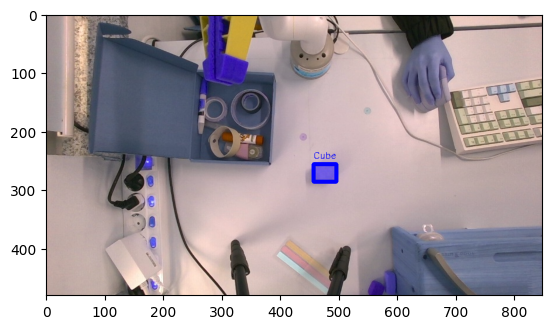

In [ ]:
img = cv2.imread(c_path)
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 5)
cv2.putText(img, f'Cube', (x1, y1 - 10),
cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    
plt.imshow(img);

# 2.Depthmap ROI 생성

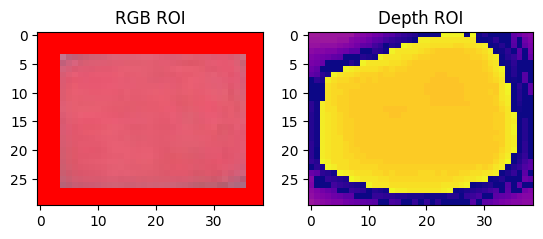

In [271]:
# RGB와 Depth 둘 다 crop해서 시각화 비교
depth = np.load(d_path)
roi_rgb = img[y1:y2, x1:x2] 
roi_depth = depth[y1:y2, x1:x2]
# roi_depth = np.nan_to_num(roi_depth, nan=0.0)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(roi_rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB ROI")

plt.subplot(1, 2, 2)
plt.imshow(roi_depth*1000,cmap="plasma")
plt.title("Depth ROI")
plt.show()


In [272]:
fx = camera_matrix[0][0]    # 수평 초점 거리
fy = camera_matrix[1][1]    # 수직 초점 거리
ppx = camera_matrix[0][2]    # center x
ppy = camera_matrix[1][2]    # center y

print(fx, fy, ppx, ppy)

425.14215 424.56403 427.1854 245.99588


In [273]:
depth.shape[1], depth.shape[0]

(848, 480)

In [274]:
roi_ppx = ppx - x1
roi_ppy = ppy - y1

roi_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=roi_depth.shape[1],
    height=roi_depth.shape[0],
    fx=fx,
    fy=fy,
    cx=roi_ppx,
    cy=roi_ppy
)

## 3. ROI Depth -> PointCloud

In [275]:
depth_contig = np.ascontiguousarray(roi_depth)
depth_o3d = o3d.geometry.Image(depth_contig)

# depth_o3d = o3d.geometry.Image(roi_depth)

dummy_gray = np.ones_like(roi_depth, dtype=np.uint8) * 128
dummy_rgb = np.stack([dummy_gray]*3, axis=2) 
dummy_color = o3d.geometry.Image(dummy_rgb)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    dummy_color,
    depth_o3d,
    depth_scale=1000,
    depth_trunc = 2.0,
    convert_rgb_to_intensity = False
)

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd,
    roi_intrinsic
)

# 좌표계 맞춤 (Open3D 시각화 기준)
pcd.transform([[1, 0, 0, 0],
               [0, -1, 0, 0],
               [0, 0, -1, 0],
               [0, 0, 0, 1]])

# 시각화
main_pcd_color = [0.008, 0.467, 0.741] 
pcd.paint_uniform_color(main_pcd_color) #0277BD 
o3d.visualization.draw_plotly([pcd],
                                  window_name = "1. Raw ROI PCD")


In [276]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.005,
    ransac_n=3,
    num_iterations=100
)

pcd = pcd.select_by_index(inliers)

o3d.visualization.draw_plotly([pcd], window_name = "2. Segmented PCD")

# 4. 각 포인트에 대해 Surface Normal 추정

In [277]:
# 3d ROI PCD로부터 각 픽셀에 대한 Surface normal 수행
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
pcd.normalize_normals()

# 평균 법선 방향 계산 
normals = np.asarray(pcd.normals)         # (N,3) 배열
avg_normal = normals.mean(axis=0)         # 평균 법선 벡터
avg_normal /= np.linalg.norm(avg_normal)  # 단위 벡터로 정규화

# PCD의 중심점(centroid) 계산
points = np.asarray(pcd.points)
if points.shape[0] == 0:
    print("Error: No points found after segmentation.")
    exit()

centroid = points.mean(axis=0)


In [283]:
z_axis = np.array([0, 0, 1])

# 회전축과 회전각을 사용하여 회전 행렬을 계산합니다.
axis = np.cross(z_axis, avg_normal)
axis_norm = np.linalg.norm(axis)
if axis_norm < 1e-6:
    rot_mat_normal = np.eye(3)
else:
    axis /= axis_norm
    angle = np.arccos(np.dot(z_axis, avg_normal))
    rot_mat_normal = Rotation.from_rotvec(axis * angle).as_matrix()
    
rot_mat_eul = Rotation.from_matrix(rot_mat_normal)
eul = rot_mat_eul.as_euler('zyx', degrees=True) # Z-Y-X (Yaw-Pitch-Roll)
yaw_normal, pitch_normal, roll_normal = eul[0], eul[1], eul[2]
yaw_normal, pitch_normal, roll_normal

(np.float64(-0.0224943415213733),
 np.float64(0.9151592149831428),
 np.float64(2.8159996274791346))

# PCA 추가

In [279]:
# 1) 원래 포인트클라우드(points) → centroid 원점 이동
points_centered = points - centroid  # shape (N,3)
if points_centered.shape[1] != 3:
    print(f"Error: PCA data must be 3-dimensional, but has shape {points_centered.shape}")
    exit()

# 2) 법선 정렬 Δ회전(rot_mat)의 역행렬로 포인트 '보정'
#    → avg_normal이 Z축으로 정렬된 상태로 변환
# R_align_inv = rot_mat_normal.T
# points_aligned = (R_align_inv.dot(points_centered.T)).T  # shape (N,3)

# # 3) XY평면(그리퍼 오픈 평면)으로 투영
# proj2d = points_aligned[:, :2]  # (x, y) 좌표만 뽑음

# 4) 2D PCA로 공분산행렬·고유벡터 계산
cov = np.cov(points_centered.T)             # 3×3
eigs, vecs = np.linalg.eigh(cov)           # 고유값 오름차순
# vecs[:, -1] 은 장축, vecs[:, -2] 는 단축(minor axis)
normal_vector = vecs[:, 0] # 최소 분산을 갖는 축 = 평면의 법선
major_axis = vecs[:, -1]   # 최대 분산을 갖는 축 = 그리퍼 개방 방향
minor_axis = vecs[:, -2]   # 중간 분산을 갖는 축
pitch_final = np.degrees(np.arccos(np.dot(normal_vector, -z_axis)))
yaw_final = np.degrees(np.arctan2(np.dot(np.cross(z_axis, major_axis), minor_axis), np.dot(z_axis, major_axis)))

final_roll = roll_normal
final_pitch = pitch_final
final_yaw = yaw_final

print(f"Final Roll (from Normal): {final_roll:.2f} degrees")
print(f"Final Pitch (from PCA): {final_pitch:.2f} degrees")
print(f"Final Yaw (from PCA): {final_yaw:.2f} degrees")

Final Roll (from Normal): 2.82 degrees
Final Pitch (from PCA): 175.74 degrees
Final Yaw (from PCA): -93.27 degrees


# 6. Cam2base 변환

In [280]:
import numpy as np
import json

def transform_rpy_cam2base(rpy_cam, cam2base_json):
    """
    Transforms RPY angles from camera frame to robot base frame.

    Args:
        rpy_cam (list or np.array): RPY angles in camera frame [roll, pitch, yaw] (in radians).
        cam2base_json (str): Path to the cam2base.json file.

    Returns:
        np.array: RPY angles in base frame [roll, pitch, yaw] (in radians).
    """
    # 1. Load the cam2base extrinsic parameters
    with open(cam2base_json, "r") as f:
        data = json.load(f)
    R_cam2base = np.array(data["R_cam2base"], dtype=np.float32).reshape(3,3)

    # 2. Convert camera RPY to a rotation matrix
    # Note: Use 'xyz' for the Roll, Pitch, Yaw order
    rot_cam = Rotation.from_euler('xyz', rpy_cam)
    R_cam = rot_cam.as_matrix()

    # 3. Combine rotations: R_base = R_cam2base * R_cam
    R_base = np.dot(R_cam2base, R_cam)

    # 4. Convert base rotation matrix back to RPY
    rot_base = Rotation.from_matrix(R_base)
    rpy_base = rot_base.as_euler('xyz')

    return rpy_base

cam2base_path = "/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_table_normal_fix_v3.json"

# 베이스 기준 절대 자세 제어
# with open(cam2base_path, "r") as f:
#     data = json.load(f)
# R_cam2base = np.array(data["R_cam2base"], dtype=np.float32).reshape(3,3)
# t_cam2base = np.array(data["t_cam2base"], dtype=np.float32).reshape(3,1)

# T_cam2base = np.eye(4, dtype=np.float32)
# T_cam2base[:3,:3] = R_cam2base
# T_cam2base[:3, 3] = t_cam2base.flatten()

rpy_cam_deg = [roll_normal, pitch_normal, final_yaw]
rpy_cam_rad = np.deg2rad(rpy_cam_deg)
rpy_base_rad = transform_rpy_cam2base(rpy_cam_rad, cam2base_path)
base_roll, base_pitch, base_yaw = np.rad2deg(rpy_base_rad)

# 그리퍼각도 45도 추가 및 정규화 진행

def wrap_deg(a):
    """[-180, 180) 범위로 정규화"""
    return (a + 180.0) % 360.0 - 180.0

base_yaw_corr = wrap_deg(base_yaw - 45.0)

print(f"Camera RPY (deg): {rpy_cam_deg}")
print(f"Base RPY (deg):   {base_roll, base_pitch, base_yaw_corr}")


Camera RPY (deg): [np.float64(2.8159996274791346), np.float64(0.9151592149831428), np.float64(-93.26503679200188)]
Base RPY (deg):   (np.float64(-177.15616181326592), np.float64(-2.505359401836855), np.float64(138.2588120025626))


In [281]:
def cam2base_correction(cam2base_path, cam_xyz):
    with open(cam2base_path, "r") as f:
        data = json.load(f)

    R_cam2base = np.array(data["R_cam2base"], dtype=float).reshape(3,3)
    t_cam2base = np.array(data["t_cam2base"], dtype=float).reshape(3)

    T_cam2base = np.eye(4)
    T_cam2base[:3,:3] = R_cam2base
    T_cam2base[:3, 3] = t_cam2base

    cam_h = np.r_[np.asarray(cam_xyz, float).reshape(3), 1.0]
    base_h = T_cam2base @ cam_h
    base_xyz = base_h[:3]*1000            # [m]
    return base_xyz

cam_xyz = result[0]["cam_xyz"]
base_x, base_y, base_z = cam2base_correction("/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_table_normal_fix_v3.json", cam_xyz)
base_x, base_y, base_z

(np.float64(255.84567369620493),
 np.float64(28.047574480795262),
 np.float64(15.520980893957702))

In [263]:
base_rpy= cam2base_correction("/home/ros/llm_robot/data/Calibration/Eye-to-Hand11/cam2base_table_normal_fix_v3.json", cam_xyz)


In [265]:
np.round(base_rpy, 1).tolist() + np.round(base_xyz, 1).tolist()

[263.1, 28.0, 15.3, 263.1, 28.0, 15.3]

# 실험

In [244]:
base_x = round(base_x, 1)
base_y = round(base_y, 1)
base_z = round(base_z, 1)
base_roll = round(base_roll, 1)
base_pitch = round(base_pitch, 1)
base_yaw = round(base_yaw, 1)
base_yaw_corr = round(base_yaw_corr, 1)
base_x, base_y, base_z, base_roll, base_pitch, base_yaw_corr

(np.float64(263.1),
 np.float64(28.0),
 np.float64(15.3),
 np.float64(-179.6),
 np.float64(-1.8),
 np.float64(138.7))

In [239]:
base_roll, base_pitch, base_yaw_corr

(np.float64(-179.62867288793063),
 np.float64(-1.794990089804426),
 np.float64(138.68514584619174))

In [254]:
import time

# 4번 영상 
# 물체로 이동
mc.set_gripper_value(70,50)
time.sleep(0.5)
mc.send_coords([base_x, base_y, 240, -base_roll, base_pitch, base_yaw_corr],40,1)
time.sleep(1.5)
mc.send_coords([base_x, base_y, 160, base_roll, base_pitch, base_yaw_corr],50,1)
time.sleep(1.5)

# 그리퍼 닫기
mc.set_gripper_state(1,50)
time.sleep(1)

# # 위로 이동
mc.send_coords([base_x, base_y, 270, base_roll, base_pitch, base_yaw_corr],60,1)
time.sleep(0.5)
# 내려놓을 위치로 이동
mc.send_coords([121.9, -126.0, 281.8, -179.12, -0.18, -114.26],60,1)
time.sleep(2)
mc.set_gripper_value(60,50)
time.sleep(1)

# 제자리 복귀
mc.set_gripper_state(1,50)
mc.send_coords([46.5, -63.7, 421.1, -89.64, 0.26, -90.43],50,1)

1

In [113]:
mc.set_gripper_state(1,60)
time.sleep(0.8)

mc.send_angles([0,0,0,0,0,0], 50)

1